In [1]:

import tushare as ts
df = ts.get_hist_data('002497')

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


In [15]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
import pandas as pd
import numpy as np

In [6]:
df = df.sort_index()
df.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
date,,,,,,,,,,,,,,
2018-12-26,6.90,6.96,6.82,6.78,121353.57,-0.08,-1.16,6.820,6.820,6.820,121353.57,121353.57,121353.57,1.49
2018-12-27,6.93,6.95,6.60,6.59,162765.00,-0.22,-3.23,6.710,6.710,6.710,142059.29,142059.29,142059.29,2.00
2018-12-28,6.66,6.76,6.64,6.58,123392.06,0.04,0.61,6.687,6.687,6.687,135836.88,135836.88,135836.88,1.51
2019-01-02,6.70,6.76,6.67,6.63,105431.06,0.03,0.45,6.683,6.683,6.683,128235.42,128235.42,128235.42,1.25
2019-01-03,6.67,6.88,6.73,6.65,147812.95,0.06,0.90,6.692,6.692,6.692,132150.93,132150.93,132150.93,1.75


In [7]:
df.corr()['close']

open            0.997069
high            0.998879
close           1.000000
low             0.998807
volume          0.631559
price_change    0.081558
p_change        0.071898
ma5             0.994418
ma10            0.987816
ma20            0.972393
v_ma5           0.698364
v_ma10          0.736938
v_ma20          0.762110
turnover        0.593986
Name: close, dtype: float64

In [11]:
# Picking the series with high correlation
df = df[['open','high','volume','ma5','ma10','close']]

In [16]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [145]:
# n_in: input timestep, n_out: output timestep
n_in = 30
n_vars = df.shape[1]
n_out = 1

In [146]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#将时间序列问题转化为监督学习问题
reframed = series_to_supervised(scaled, n_in, n_out)

In [147]:
# drop input Y and output X, if n_out > 1 need extra work 
reframed = reframed.drop(reframed.columns[[ (n * n_vars - 1) for n in range(1,n_in+1)]], axis =1)
data = reframed.drop(reframed.columns[[ -n for n in range(2,n_vars+1)]], axis =1)

In [148]:
#分隔数据集，分为训练集和测试集
train_proportion = 0.8

values = data.values
n_train = round(data.shape[0]*train_proportion)
train = values[:n_train, :]
test = values[n_train:, :]

#分隔输入X和输出y
train_X, train_y = train[:, :n_in*(n_vars-1)], train[:, n_in*(n_vars-1):]
test_X, test_y = test[:, :n_in*(n_vars-1)], test[:, n_in*(n_vars-1):]

#将输入X改造为LSTM的输入格式，即[samples,timesteps,features]
train_X = train_X.reshape((train_X.shape[0], n_in, (n_vars-1)))
test_X = test_X.reshape((test_X.shape[0], n_in, (n_vars-1)))

In [149]:
from tensorflow.keras.callbacks import EarlyStopping
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [150]:
#定义拟合LSTM模型的函数
def fit_lstm(data_prepare, n_neurons=50, n_batch=72, n_epoch=100, loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], repeats=1):
    train_X = data_prepare[2]
    train_y = data_prepare[3]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    model_list = []
    for i in range(repeats):
        #设计神经网络
        model = Sequential()
        model.add(LSTM(n_neurons,return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(0.2))
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50, return_sequences = True))
        model.add(Dropout(0.2))
        # Adding a third LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50, return_sequences = True))
        model.add(Dropout(0.2))
        # Adding a fourth LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 50))
        model.add(Dropout(0.2))
        # Adding the output layer
        model.add(Dense(units = 1))
        # Compiling the RNN
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        #拟合神经网络
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks=callbacks_list)
        #画出学习过程
        p1 = pyplot.plot(history.history['loss'], color='blue', label='train_loss')
        p2 = pyplot.plot(history.history['val_loss'], color='yellow',label='test_loss')
        #保存model
        model_list.append(model)
    pyplot.legend(["train_loss","test_loss"])
    pyplot.show()
    return model_list

def lstm_predict(model, data_prepare,scaler):
    """
    定义预测的函数
    """
    #scaler = data_prepare[0]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    #做出预测
    yhat = model.predict(test_X)
    #将测试集上的预测值还原为原来的数据维度
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    #将测试集上的实际值还原为原来的数据维度
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(y_hat_list,y_test_list):
    mse_list = []
    rmse_list = []
    r_list = []
    for Y_test,Y_hat in zip(y_test_list,y_hat_list):
        mse = mean_squared_error(Y_test,Y_hat)
        rmse = sqrt(mse)
        r = r2_score(Y_test,Y_hat)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r_list.append(r)
    return mse_list, rmse_list, r_list

import matplotlib.pyplot as plt
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

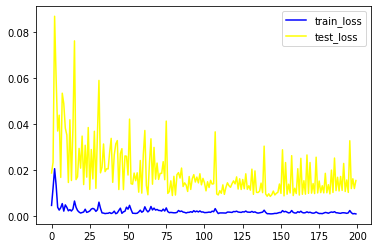

In [151]:
# 1.trian model
n_neuron = 50
n_batch = 16
n_epoch = 400
repeats = 1
data_prepare = ['', '', train_X, train_y, test_X, test_y, '']
model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch,repeats=repeats)

In [152]:
# 2.validate score
inv_yhat_list = []
inv_y_list = []
for i in range(len(model_list)):
    model = model_list[i]
    inv_yhat = lstm_predict(model, data_prepare, scaler)[0]
    inv_y = lstm_predict(model, data_prepare, scaler)[1]
    inv_yhat_list.append(inv_yhat)
    inv_y_list.append(inv_y)

mse_list, rmse_list, r_list = evaluate_model(inv_yhat_list,inv_y_list)
mse_list, rmse_list, r_list

([8.571726261786093], [2.927751058711463], [0.1857611980204581])

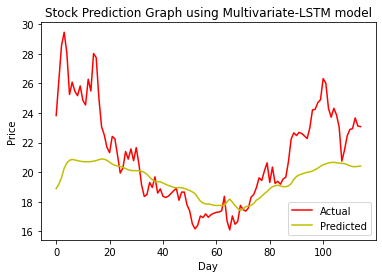

In [153]:
# 3.plot price
plot_data(inv_y_list[0],inv_yhat_list[0])